In [1]:
import torch
import xlab
import matplotlib.pyplot as plt

device = xlab.utils.get_best_device()

## Loading the MNIST Dataset

Before we begin the attack, let's take a look at our data and the surrogate models we will be using for this notebook. First, you can see that the `xlab-security` packages provides you with `xlab.utils.load_mnist_test_samples` which you can use to load members of the MNIST handwritten digit test set.

In [2]:
mnist_images, mnist_labels = xlab.utils.load_mnist_test_samples(100)
print(f"Images shape: {mnist_images.shape}")
print(f"Labels shape: {mnist_labels.shape}")

Images shape: torch.Size([100, 1, 28, 28])
Labels shape: torch.Size([100])


We also provide you with `xlab.utils.show_grayscale_image` to plot MNIST images. You can change the `image_index` below to explore different images in the dataset.

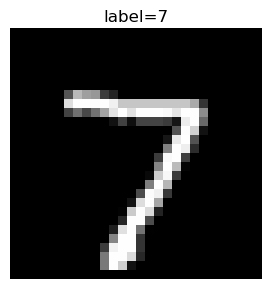

In [3]:
image_index = 0
xlab.utils.show_grayscale_image(mnist_images[image_index], title=f"label={mnist_labels[image_index]}")

## Loading White-Box Models

Next let's load the models that we will use to generate our transferable adversarial examples. We will be using a diverse set of models:

1. **A Resnet model**, similar to the MiniWideResnet model you used in previous sections.
   * Test set accuracy: 97.61%
3. **A CNN model**, which is a simple model that has three convolutional layers and three dense layers.
   * Test set accuracy: 96.74%
5. **A MLP model** which contains three standard fully connected layers.
   * Test set accuracy: 94.27%

Code for how we trained each of these models can be found [here](https://github.com/zroe1/xlab-ai-security/tree/main/models/MNIST_ensemble). To load the models on your computer, you can run the cells below.

In [4]:
from huggingface_hub import hf_hub_download
from xlab.models import ConvolutionalMNIST, ResNetMNIST, BasicBlockMNIST, FeedforwardMNIST

model_path = hf_hub_download(
    repo_id="uchicago-xlab-ai-security/mnist-ensemble",
    filename="mnist_wideresnet.pth"
)
white_box1 = torch.load(model_path, map_location=device, weights_only=False)


model_path = hf_hub_download(
    repo_id="uchicago-xlab-ai-security/mnist-ensemble",
    filename="mnist_simple_cnn.pth"
)
white_box2 = torch.load(model_path, map_location=device, weights_only=False)


model_path = hf_hub_download(
    repo_id="uchicago-xlab-ai-security/mnist-ensemble",
    filename="mnist_mlp.pth"
)
white_box3 = torch.load(model_path, map_location=device, weights_only=False)


## Loading Black-Box Models

Now we can load our black box model which we will attempt to attack in this notebook. You will interact with this model through our python package and you wont be able to see anything about the model architecture. You will be able to only call `model.predict` to get model predictions for a set of images and `model.predict_proba` to get model probabilities for a set of images.

In [5]:
import xlab
from xlab.models import BlackBox

# Load the black box model (downloads automatically)
model = xlab.utils.load_black_box_model('mnist-black-box')

# Make predictions (model details are hidden)
predictions = model.predict(mnist_images)
probabilities = model.predict_proba(mnist_images)

print(f"predictions={predictions}")
print(f"probabilities.shape={probabilities.shape}")

predictions=tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 2, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 0, 7, 2, 7, 1, 3, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 4, 3, 7, 4, 2, 4, 3, 0, 7, 0,
        2, 7, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 4, 3, 1, 4,
        1, 7, 6, 9])
probabilities.shape=torch.Size([100, 10])


## Task #1: Ensemble Loss

Given an array of $k$ alpha values and $k$ models you will give the weighted cross entropy loss by the following equation:

$$
\mathrm{argmin}_\delta \  \  D(\delta) + \sum_{i=1}^k \alpha_i \cdot \ell_i(x + \delta)
$$

In [6]:
def ensemble_loss(alphas, models, img, target):
    loss = torch.tensor(0.0).to(device)
    loss_fn = torch.nn.CrossEntropyLoss()

    for alpha, model in zip(alphas, models):
        out = model(img)
        model_loss = loss_fn(out, target)
        loss += alpha * model_loss
        # print(model_loss)

    return loss

In [7]:
img = mnist_images[0:1].to(device)
alphas = [1/3, 1/3, 1/3]
models = [white_box1, white_box2, white_box3]

example_loss = ensemble_loss(alphas, models, img, torch.tensor([0]).to(device))

## Task #2: Ensemble Attack

Now you should be in a good position to complete the ensemble attack. This is exactly the same as PGD, but instead of using a typical loss like Cross Entropy, you will be using the ensemble loss you implemented in `Task #1`. Note that in the original paper, the authors implement something more similar to Carlini-Wagner with a hyperparameter $\lambda$ which controls how much the distance metric is weighted in the final loss. For simplicity and compatibility with our tests you should use the update rule below:

$$
x'_i = x + \mathrm{clip}_\epsilon(\alpha \cdot \mathrm{sign}(\nabla \mathrm{ensemble\_loss}_{F,t}(x'_{i-1})))
$$

For the purpose of not making this too difficult, we have allowed a very high $\epsilon$ value. While one may exect $\epsilon=28/255$ to yeild some absurd results, in practice this is somewhat reasonable because of the high-contrast nature of the dataset. Also, because it is a gray-scale image, there are fewer pixel values to work with so the total distance of the purturbation (if you take the absolute value and sum) will be comparable to (probably less than) $\epsilon=12/255$ for a color image.

<b>Note:</b> You may use our solution to the clip function from the PGD notebook by calling `xlab.utils.clip`. You can also implement this functionality again within this notebook if you prefer.

In [35]:
def ensemble_attack_PGD(alphas, models, img, target, epsilon=28/255, alpha=3/255, num_iters=50):
    img_original = img.clone()
    # adv_img = img.clone()
    adv_img = xlab.utils.add_noise(img)

    for _ in range(num_iters):
        adv_img.requires_grad=True
        loss = ensemble_loss(alphas, models, adv_img, target)
        loss.backward()
        print(loss)

        grad = adv_img.grad.data
        # print(grad)
        adv_img.requires_grad_(False)
        adv_img -= alpha * torch.sign(grad)
        adv_img = xlab.utils.clip(adv_img, img_original, epsilon)

    return adv_img

img = mnist_images[2:3].to(device)
adv_img = ensemble_attack_PGD(alphas, models, img, torch.tensor([2]).to(device))

tensor(8.4048, device='mps:0', grad_fn=<AddBackward0>)
tensor(7.6266, device='mps:0', grad_fn=<AddBackward0>)
tensor(6.7506, device='mps:0', grad_fn=<AddBackward0>)
tensor(5.8986, device='mps:0', grad_fn=<AddBackward0>)
tensor(5.1280, device='mps:0', grad_fn=<AddBackward0>)
tensor(4.4790, device='mps:0', grad_fn=<AddBackward0>)
tensor(3.9689, device='mps:0', grad_fn=<AddBackward0>)
tensor(3.5822, device='mps:0', grad_fn=<AddBackward0>)
tensor(3.2758, device='mps:0', grad_fn=<AddBackward0>)
tensor(2.9847, device='mps:0', grad_fn=<AddBackward0>)
tensor(2.8864, device='mps:0', grad_fn=<AddBackward0>)
tensor(2.8170, device='mps:0', grad_fn=<AddBackward0>)
tensor(2.6653, device='mps:0', grad_fn=<AddBackward0>)
tensor(2.4787, device='mps:0', grad_fn=<AddBackward0>)
tensor(2.3550, device='mps:0', grad_fn=<AddBackward0>)
tensor(2.2017, device='mps:0', grad_fn=<AddBackward0>)
tensor(2.0672, device='mps:0', grad_fn=<AddBackward0>)
tensor(1.9841, device='mps:0', grad_fn=<AddBackward0>)
tensor(1.9

tensor(12.9572, device='mps:0', grad_fn=<AddBackward0>)
tensor(11.9901, device='mps:0', grad_fn=<AddBackward0>)
tensor(10.9585, device='mps:0', grad_fn=<AddBackward0>)
tensor(9.8587, device='mps:0', grad_fn=<AddBackward0>)
tensor(8.6614, device='mps:0', grad_fn=<AddBackward0>)
tensor(7.4661, device='mps:0', grad_fn=<AddBackward0>)
tensor(6.2270, device='mps:0', grad_fn=<AddBackward0>)
tensor(5.3904, device='mps:0', grad_fn=<AddBackward0>)
tensor(4.8147, device='mps:0', grad_fn=<AddBackward0>)
tensor(4.2426, device='mps:0', grad_fn=<AddBackward0>)
tensor(3.8916, device='mps:0', grad_fn=<AddBackward0>)
tensor(3.6686, device='mps:0', grad_fn=<AddBackward0>)
tensor(3.4590, device='mps:0', grad_fn=<AddBackward0>)
tensor(3.2634, device='mps:0', grad_fn=<AddBackward0>)
tensor(3.1137, device='mps:0', grad_fn=<AddBackward0>)
tensor(3.0113, device='mps:0', grad_fn=<AddBackward0>)
tensor(2.9380, device='mps:0', grad_fn=<AddBackward0>)
tensor(2.8884, device='mps:0', grad_fn=<AddBackward0>)
tensor(

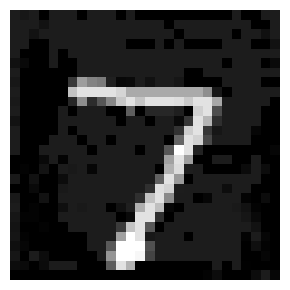

tensor([3])


In [36]:
img = mnist_images[0:1].to(device)
adv_img = ensemble_attack_PGD(alphas, models, img, torch.tensor([8]).to(device))
xlab.utils.show_grayscale_image(adv_img[0])
predictions = model.predict(adv_img)
print(predictions)

tensor(11.6191, device='mps:0', grad_fn=<AddBackward0>)
tensor(10.9355, device='mps:0', grad_fn=<AddBackward0>)
tensor(10.1944, device='mps:0', grad_fn=<AddBackward0>)
tensor(9.5048, device='mps:0', grad_fn=<AddBackward0>)
tensor(8.8643, device='mps:0', grad_fn=<AddBackward0>)
tensor(8.1980, device='mps:0', grad_fn=<AddBackward0>)
tensor(7.4779, device='mps:0', grad_fn=<AddBackward0>)
tensor(6.7716, device='mps:0', grad_fn=<AddBackward0>)
tensor(6.0894, device='mps:0', grad_fn=<AddBackward0>)
tensor(5.5029, device='mps:0', grad_fn=<AddBackward0>)
tensor(5.2242, device='mps:0', grad_fn=<AddBackward0>)
tensor(5.1060, device='mps:0', grad_fn=<AddBackward0>)
tensor(5.0075, device='mps:0', grad_fn=<AddBackward0>)
tensor(4.9228, device='mps:0', grad_fn=<AddBackward0>)
tensor(4.8338, device='mps:0', grad_fn=<AddBackward0>)
tensor(4.7522, device='mps:0', grad_fn=<AddBackward0>)
tensor(4.6991, device='mps:0', grad_fn=<AddBackward0>)
tensor(4.6452, device='mps:0', grad_fn=<AddBackward0>)
tensor(

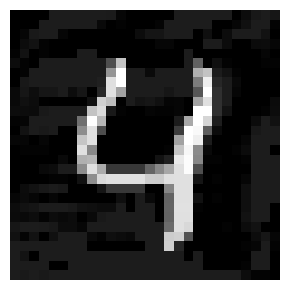

tensor([7])


In [37]:
img = mnist_images[4:5].to(device)
adv_img = ensemble_attack_PGD(alphas, models, img, torch.tensor([7]).to(device))
xlab.utils.show_grayscale_image(adv_img[0])
predictions = model.predict(adv_img)
print(predictions)

tensor(12.1788, device='mps:0', grad_fn=<AddBackward0>)
tensor(11.4449, device='mps:0', grad_fn=<AddBackward0>)
tensor(10.6826, device='mps:0', grad_fn=<AddBackward0>)
tensor(9.9585, device='mps:0', grad_fn=<AddBackward0>)
tensor(9.3166, device='mps:0', grad_fn=<AddBackward0>)
tensor(8.7775, device='mps:0', grad_fn=<AddBackward0>)
tensor(8.2304, device='mps:0', grad_fn=<AddBackward0>)
tensor(7.6381, device='mps:0', grad_fn=<AddBackward0>)
tensor(6.9833, device='mps:0', grad_fn=<AddBackward0>)
tensor(6.1947, device='mps:0', grad_fn=<AddBackward0>)
tensor(5.7359, device='mps:0', grad_fn=<AddBackward0>)
tensor(5.5034, device='mps:0', grad_fn=<AddBackward0>)
tensor(5.3254, device='mps:0', grad_fn=<AddBackward0>)
tensor(5.1426, device='mps:0', grad_fn=<AddBackward0>)
tensor(5.0393, device='mps:0', grad_fn=<AddBackward0>)
tensor(4.9233, device='mps:0', grad_fn=<AddBackward0>)
tensor(4.8605, device='mps:0', grad_fn=<AddBackward0>)
tensor(4.7669, device='mps:0', grad_fn=<AddBackward0>)
tensor(

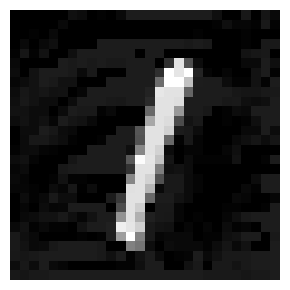

tensor([3])


In [38]:
img = mnist_images[5:6].to(device)
adv_img = ensemble_attack_PGD(alphas, models, img, torch.tensor([3]).to(device))
xlab.utils.show_grayscale_image(adv_img[0])
predictions = model.predict(adv_img)
print(predictions)

In [62]:
predictions = model.predict(adv_img)

In [63]:
predictions

tensor([2])

In [12]:
img.shape

torch.Size([1, 1, 28, 28])

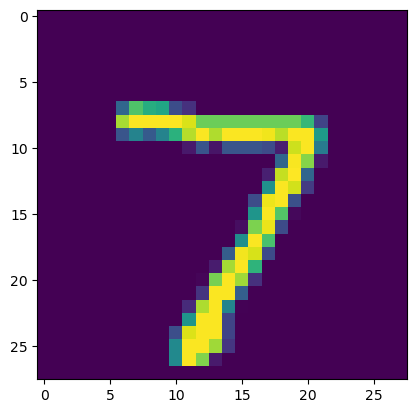

In [12]:
plt.imshow(mnist_images[0][0])

In [3]:
from huggingface_hub import hf_hub_download
from xlab.models import ConvolutionalMNIST

# https://huggingface.co/uchicago-xlab-ai-security/tiny-wideresnet-cifar10
model_path = hf_hub_download(
    repo_id="uchicago-xlab-ai-security/mnist-ensemble",
    filename="mnist_simple_cnn.pth"
)
model = torch.load(model_path, map_location='cpu', weights_only=False)
_ = model.eval()

mnist_simple_cnn.pth:   0%|          | 0.00/432k [00:00<?, ?B/s]

In [3]:
model(mnist_images[0:1])

NameError: name 'model' is not defined

In [4]:
from huggingface_hub import hf_hub_download
from xlab.models import ResNetMNIST, BasicBlockMNIST

# https://huggingface.co/uchicago-xlab-ai-security/tiny-wideresnet-cifar10
model_path = hf_hub_download(
    repo_id="uchicago-xlab-ai-security/mnist-ensemble",
    filename="mnist_wideresnet.pth"
)
model = torch.load(model_path, map_location='cpu', weights_only=False)
_ = model.eval()


mnist_wideresnet.pth:   0%|          | 0.00/693k [00:00<?, ?B/s]

In [5]:
model(mnist_images[0:1])

tensor([[-8.7614, -0.1434, -2.2696, -2.6548, -0.9835, -6.6371, -9.8690,  6.9030,
         -8.5592,  0.1233]], grad_fn=<AddmmBackward0>)

In [3]:
from huggingface_hub import hf_hub_download
from xlab.models import FeedforwardMNIST

# https://huggingface.co/uchicago-xlab-ai-security/tiny-wideresnet-cifar10
model_path = hf_hub_download(
    repo_id="uchicago-xlab-ai-security/mnist-ensemble",
    filename="mnist_mlp.pth"
)
model = torch.load(model_path, map_location='cpu', weights_only=False)
_ = model.eval()

mnist_mlp.pth:   0%|          | 0.00/166k [00:00<?, ?B/s]

In [4]:
model(mnist_images[0:1])

tensor([[ -0.2652, -10.5678,   0.7676,   4.0928, -10.3465,   0.0514, -15.9896,
           9.2350,  -2.0897,   2.2656]], grad_fn=<AddmmBackward0>)